### INTRO
---

This notebook consists of several parts:

- competition data checks and clean up
- interactive data inspector widgets with Ipython (**YOU NEED TO RUN THE NOTEBOOK TO SEE THE WIDGETS AND THEIR OUTPUT**)
- preparation of data and creation of neural network for prediction of asleep state (target)
- test data pre- and post- processing, prediction and preparation for submission (**)

(**) If you try to make a submission from this notebook, it will fail with a "Notebook Threw Exception" error. I have been able to make succesful submissions with other notebooks based on this one, after splitting the data pre-processing, the model training and the test data predictions three separate notebooks, but remember this is just an EDA analysis and proof-of-concept notebook, and as such you may find errors, omissions or sub-optimal and unfinished bits.

---

**WARNING: Be aware that training the neural network with a large number of series_id and EPOCH may take several hours**  

---

### Library imports and data loading
---

In [59]:
import os
import gc
import numpy as np
import pandas as pd
import random
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, Functional, Model
from keras.layers import Input, Conv1D, Dense, LSTM, Dropout, Bidirectional
from keras.optimizers import Adam, Adamax
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

# Set precision to two decimals
pd.set_option("display.precision", 2)

# Charts inline
%matplotlib inline

# Ignore warning
warnings.filterwarnings("ignore")

# List files 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet


In [60]:
print('Reading files.....')
path = '/kaggle/input/child-mind-institute-detect-sleep-states/'
train_events = pd.read_csv(path + 'train_events.csv')
train_series = pd.read_parquet(path + 'train_series.parquet')
test_series = pd.read_parquet(path + 'test_series.parquet')
sample_submission = pd.read_csv(path + 'sample_submission.csv')
print('..... done!')

Reading files.....
..... done!


### Training data inspection and clean up
---

Any event records without time information is of no use, so I´ll start removing those.

Also, each night can have only two events, one onset and one wakeup, so any nights breaking the rule will be discarded too.

In [61]:
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14508 non-null  object 
 1   night      14508 non-null  int64  
 2   event      14508 non-null  object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.8+ KB


Let´s start removing any event records without time information.

In [62]:
train_events = train_events.dropna(axis=0, ignore_index=True)
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9585 entries, 0 to 9584
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  9585 non-null   object 
 1   night      9585 non-null   int64  
 2   event      9585 non-null   object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 374.5+ KB


Now let´s look for any instances of "bad nights" meaning any nights with anything different to a single onset / wakeup pair.

In [63]:
bad_nights = train_events[['series_id', 'night', 'event']].groupby(by=['series_id', 'night']).count()
bad_nights[bad_nights['event']!=2]

,,event
series_id,night,
0ce74d6d2106,20,1
154fe824ed87,30,1
44a41bba1ee7,10,1
efbfc4526d58,7,1
f8a8da8bdd00,17,1


So here we have a few of such cases, with just one event.

In [64]:
 train_events[(((train_events['series_id']=='0ce74d6d2106') & (train_events['night']==20)) |
               ((train_events['series_id']=='154fe824ed87') & (train_events['night']==30)) |
               ((train_events['series_id']=='44a41bba1ee7') & (train_events['night']==10)) |                
               ((train_events['series_id']=='efbfc4526d58') & (train_events['night']==7)) |
               ((train_events['series_id']=='f8a8da8bdd00') & (train_events['night']==17)))]

,series_id,night,event,step,timestamp
310,0ce74d6d2106,20,onset,332376.0,2017-09-09T22:08:00-0400
957,154fe824ed87,30,wakeup,514980.0,2019-02-25T09:45:00-0500
2668,44a41bba1ee7,10,wakeup,165684.0,2018-03-04T08:07:00-0500
9099,efbfc4526d58,7,wakeup,114864.0,2018-12-21T07:47:00-0500
9352,f8a8da8bdd00,17,wakeup,291384.0,2017-12-10T12:57:00-0500


This data is problematic, so I'll remove these records.

In [65]:
train_events = train_events[~(((train_events['series_id']=='0ce74d6d2106') & (train_events['night']==20)) |
                              ((train_events['series_id']=='154fe824ed87') & (train_events['night']==30)) |
                              ((train_events['series_id']=='44a41bba1ee7') & (train_events['night']==10)) |                
                              ((train_events['series_id']=='efbfc4526d58') & (train_events['night']==7)) |
                              ((train_events['series_id']=='f8a8da8bdd00') & (train_events['night']==17)))].reset_index(drop=True)

train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9580 entries, 0 to 9579
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  9580 non-null   object 
 1   night      9580 non-null   int64  
 2   event      9580 non-null   object 
 3   step       9580 non-null   float64
 4   timestamp  9580 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 374.3+ KB


In [66]:
series_list = list(train_events['series_id'].unique())
print('Total number of valid series in training dataset: '+ str(len(series_list)))

Total number of valid series in training dataset: 269


In [67]:
# Update train_series dataset with final set of series
train_series = train_series[train_series['series_id'].isin(series_list)].reset_index(drop=True)
# Check for nulls
train_series.isnull().any()

series_id    False
step         False
timestamp    False
anglez       False
enmo         False
dtype: bool

### A look at the test series and submission sample
---

The test series data gives us a very important requirement: we have to try and detect events (onset, wakeup) in sequences of 150 steps (x 5 sec/step = 750 seconds = 12.5 minutes).

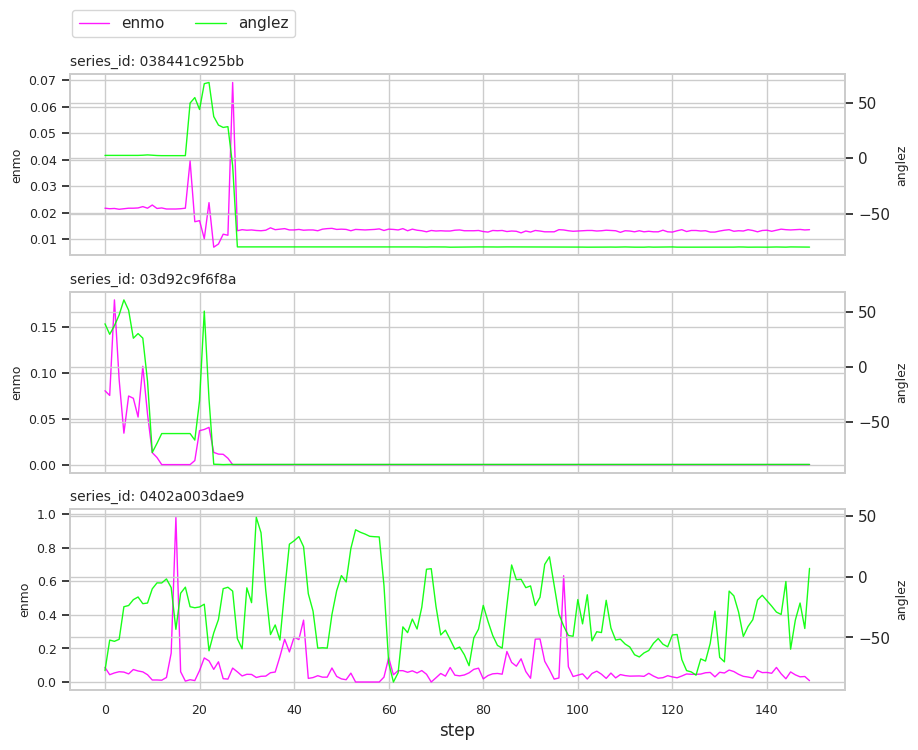

In [68]:
def plot_test_series():
    fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
    ax2 = {}
    i = 0
    test_series_list = list(test_series['series_id'].unique())
    for id in test_series_list:
        ax[i].set_title('series_id: ' + id, loc='left', fontsize=10)
        x = test_series[test_series['series_id']==id]['step']
        y_enmo = test_series[test_series['series_id']==id]['enmo']
        y_anglez = test_series[test_series['series_id']==id]['anglez']
        ax[i].plot(x, y_enmo, label='enmo', color='magenta', lw=1, alpha=0.9)
        ax[i].set_ylabel('enmo', fontsize=9)
        ax[i].tick_params(labelsize=9)
        ax2[i] = ax[i].twinx()
        ax2[i].plot(x, y_anglez, label='anglez', color='lime', lw=1, alpha=0.9)
        ax2[i].set_ylabel('anglez', fontsize=9)
        i = i + 1
    h1, l1 = ax[2].get_legend_handles_labels()
    h2, l2 = ax2[2].get_legend_handles_labels()
    plt.figlegend(h1+h2, l1+l2, loc='upper left', bbox_to_anchor=(0.12, 0.97, 0.0, 0.0), ncols=2)
    ax[2].set_xlabel('step')
    plt.show()

# Plot it
plot_test_series()

In [69]:
test_series.isnull().any()

series_id    False
step         False
timestamp    False
anglez       False
enmo         False
dtype: bool

In [70]:
sample_submission

,row_id,series_id,step,event,score
0,0,038441c925bb,100,onset,0.0
1,1,038441c925bb,105,wakeup,0.0
2,2,03d92c9f6f8a,80,onset,0.5
3,3,03d92c9f6f8a,110,wakeup,0.5
4,4,0402a003dae9,90,onset,1.0
5,5,0402a003dae9,120,wakeup,1.0


### Subsampling (ONLY FOR DEVELOPMENT) and merge of train series and events datasets
---

The training_series data file is too hefty so I just sampled it down whilst developing the solution.

The actual number of series is set in the first line of the following code cell.

In [71]:
%%time
NBR_TRAINING_SERIES = 200
full_series = series_list
selected_series = random.sample(full_series, NBR_TRAINING_SERIES)

# Subsample data
train_series = train_series[train_series['series_id'].isin(selected_series)]
train_events = train_events[train_events['series_id'].isin(selected_series)]

# Merge train_series and train_events into a single fat dataframe
train_merged = pd.merge(train_series, train_events, on=['series_id', 'step', 'timestamp'], how='outer').reset_index(drop=True)

print('Nbr. of selected training series: ' + str(NBR_TRAINING_SERIES))
print('Nbr. of data points (timesteps): ' + str(len(train_merged)))
print()

Nbr. of selected training series: 200
Nbr. of data points (timesteps): 94251780

CPU times: user 1min 56s, sys: 17.4 s, total: 2min 13s
Wall time: 2min 13s


### Full series inspector widget
---

This widget allows you to browse through the selected series of accelerometer readings. In each case, all the nights and events registered for that series are displayed.

In [72]:
def plot_series_and_events(series_id, train_merged):
    # Make local copy of datasets
    data = train_merged.copy()
    # Filter the DataFrame based on the series_id
    sample_series = data[data['series_id'] == series_id].copy()
    # Convert timestamp to Pandas datetime object
    sample_series['Date'] = sample_series['timestamp'].str.split('T', expand=True)[0]
    sample_series['Time'] = sample_series['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
    sample_series['timestamp'] = pd.to_datetime(sample_series['Date'] + ' ' + sample_series['Time'])
    # Filter event data based on the series_id
    sample_events = data[data['series_id'] == series_id].copy()
    sample_events['Date'] = sample_events['timestamp'].str.split('T', expand=True)[0]
    sample_events['Time'] = sample_events['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
    sample_events['timestamp'] = pd.to_datetime(sample_events['Date'] + ' ' + sample_events['Time'])
    # Separate events
    sample_onset = sample_events[sample_events['event'] == 'onset'] #.dropna()
    sample_wakeup = sample_events[sample_events['event'] == 'wakeup'] #.dropna()
    ####################################
    # Plot anglez and enmo along with onset and wakeup events
    fig, ax = plt.subplots(2, 1, figsize=(16, 4), sharex=True)
    fig.suptitle('Accelerometer readings (enmo, anglez) and annotated events for series_id = ' + series_id,
                 fontsize=13, y=0.95)
    ####################################    
    for onset in sample_onset['timestamp']:
        ax[0].axvline(x=onset, color='Navy', linestyle='--', label='onset', alpha=0.8)
    for wakeup in sample_wakeup['timestamp']:
        ax[0].axvline(x=wakeup, color='Red', linestyle='--', label='wakeup', alpha=0.8)    
    ax[0].plot(sample_series['timestamp'], sample_series['enmo'], label='enmo',
               linewidth=1, color='magenta', alpha=0.4)    
    ax[0].set_ylabel('enmo', fontsize=11)    
    handles, labels = ax[0].get_legend_handles_labels()
    new_labels, new_handles = [], []
    for handle, label in zip(handles, labels):
        if label not in new_labels:
            new_handles.append(handle)
            new_labels.append(label)
    ax[0].legend(new_handles, new_labels, loc='best', fontsize=10)            
    ####################################    
    for onset in sample_onset['timestamp']:
        ax[1].axvline(x=onset, color='Navy', ls='--', label='onset', alpha=0.8)        
    for wakeup in sample_wakeup['timestamp']:
        ax[1].axvline(x=wakeup, color='Red', ls='--', label='wakeup', alpha=0.8)        
    ax[1].plot(sample_series['timestamp'], sample_series['anglez'], label='anglez',
               linewidth=1, color='lime', alpha=0.4)    
    ax[1].set_ylabel('anglez',fontsize=11)    
    handles, labels = ax[1].get_legend_handles_labels()
    new_labels, new_handles = [], []
    for handle, label in zip(handles, labels):
        if label not in new_labels:
            new_handles.append(handle)
            new_labels.append(label)
    ax[1].legend(new_handles, new_labels, loc='best', fontsize=10)        
    ####################################    
    plt.xlabel('timestamp')
    plt.show()

# Selector box handlenr function 
def series_selector_eventhandler(change):
    selection = series_selector.value
    output.clear_output(wait=True)
    with output:
        plot_series_and_events(selection, train_merged)   

#################################
# Build and display widget
series_selector = widgets.Select(description='Series_id', options=selected_series, value=selected_series[0], rows=8)
series_selector.observe(series_selector_eventhandler, names='value')
output = widgets.Output()
display(series_selector, output)
#################################

with output:
    plot_series_and_events(series_selector.value, train_merged)

Select(description='Series_id', options=('405df1b41f9f', '752900afe3a6', 'f981a0805fd0', '29d3469bd15d', 'e8d0…

Output()

### Single events inspector widget
---

This widget allows you to browse through individual nights, showing enmo and anglez readings, along with the onset and wakeup events, in a window including the sleep period plus / minus six hours.

Sometimes, an error may occur if one specific series does not have a pair onset / wakeup registered for one night. Just click on another night to continue.

### Creation of target column 'asleep' and visualization against accelerometer readings (predictors) and annotated events
---

The charts show two training sequences, one for an onset event and one for a wakeup, selected randomly from the full sample.

Each sequence (or event sample) consists of 150 timesteps centered around the annotated event.

In [108]:
onset_records = list(train_merged[train_merged['event']=='onset'].index)
onset_samples = {}

for id in onset_records:
    onset_samples[id] = train_merged.iloc[id - 75 : id + 75].copy()
    onset_samples[id]['asleep'] = 0
    onset_samples[id]['asleep'] = onset_samples[id]['event'].replace({"onset":1})
    onset_samples[id]['asleep'] = onset_samples[id]['asleep'].ffill(axis ='rows')
    onset_samples[id]['asleep'].fillna(value=0, inplace=True)
    
nbr_onset_samples = len(onset_samples.keys())
# print(onset_records)
print("Nbr. onset samples for training: " + str(nbr_onset_samples))

Nbr. onset samples for training: 3568


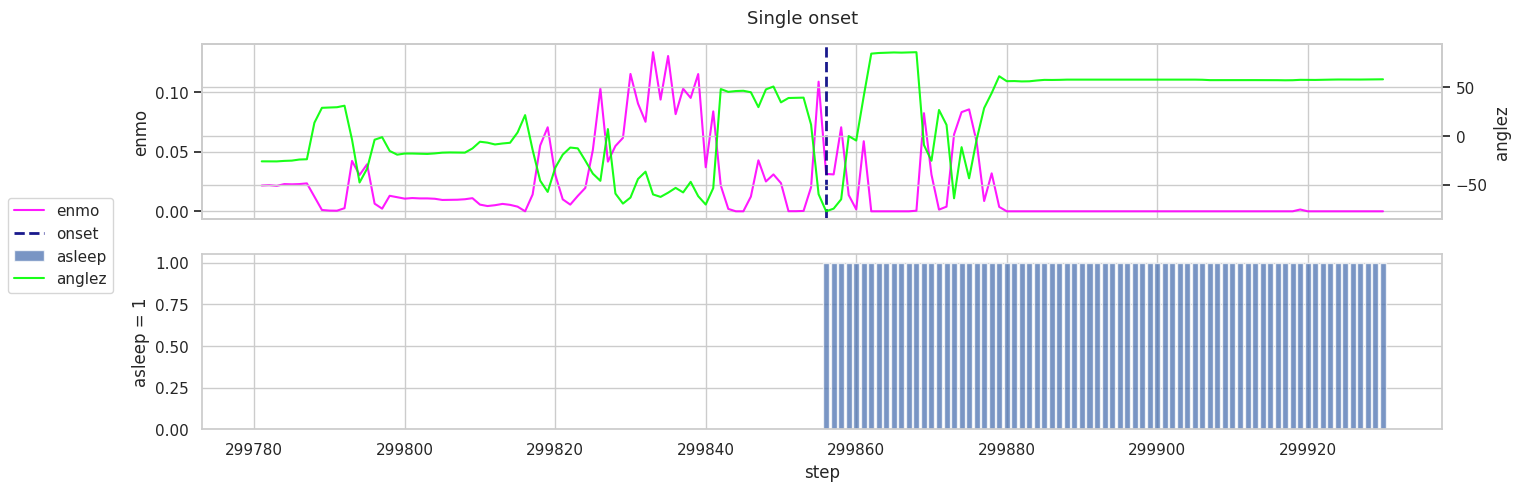

In [74]:
# Pick one onset_id randomly
onset_id = random.choice(onset_records)
# Plot enmo, anglez, event and asleep
fig, ax = plt.subplots(2,1, figsize=(16, 5), sharex=True)
fig.suptitle('Single onset', fontsize=13, y=0.95)
ax[0].plot(onset_samples[onset_id].step, onset_samples[onset_id].enmo, label='enmo', color='magenta', alpha=0.9)
ax[0].set_ylabel('enmo')
#####################
ax0b = ax[0].twinx()
ax0b.plot(onset_samples[onset_id].step, onset_samples[onset_id].anglez, label='anglez', color='lime', alpha=0.9)
ax0b.set_ylabel('anglez')
#####################
ax[0].axvline(train_merged.iloc[onset_id]['step'], label='onset', ls='--', lw=2, color='Navy', alpha=0.9) 
#####################
ax[1].bar(onset_samples[onset_id].step, onset_samples[onset_id].asleep, label='asleep', alpha=0.75)
ax[1].set_ylabel('asleep = 1')
ax[1].set_xlabel('step')
#####################
fig.legend(loc='center left', fontsize=11)
plt.show()

In [104]:
wakeup_records = list(train_merged[train_merged['event']=='wakeup'].index)
wakeup_samples = {}

for id in wakeup_records:
    wakeup_samples[id] = train_merged.iloc[id - 75 : id + 75].copy()
    wakeup_samples[id]['asleep'] = 0
    wakeup_samples[id]['asleep'] = wakeup_samples[id]['event'].replace({"wakeup":1})
    wakeup_samples[id]['asleep'] = wakeup_samples[id]['asleep'].bfill(axis ='rows')
    wakeup_samples[id]['asleep'].fillna(value=0, inplace=True)

nbr_wakeup_samples = len(wakeup_samples.keys())
# print(wakeup_samples)
print("Nbr. wakeup samples for training: " + str(nbr_wakeup_samples))

Nbr. wakeup samples for training: 3568


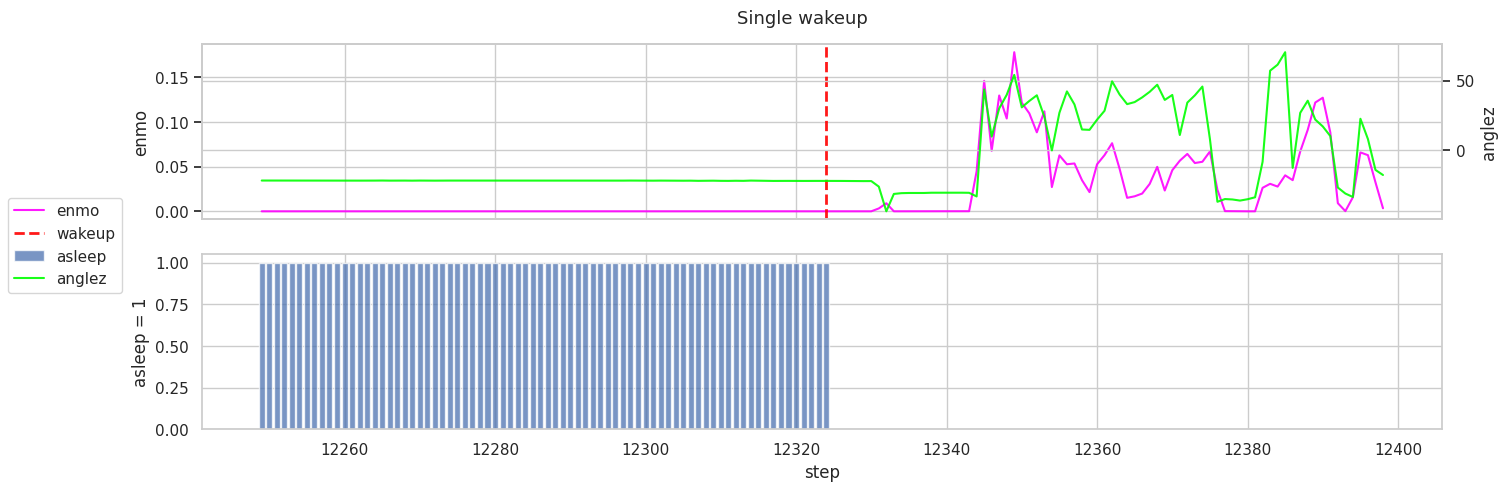

In [76]:
# Pick one wakeup_id randomly
wakeup_id = random.choice(wakeup_records)
# Plot enmo, anglez, event and asleep
fig, ax = plt.subplots(2,1, figsize=(16, 5), sharex=True)
fig.suptitle('Single wakeup', fontsize=13, y=0.95)
ax[0].plot(wakeup_samples[wakeup_id].step, wakeup_samples[wakeup_id].enmo, label='enmo', color='magenta', alpha=0.9)
ax[0].set_ylabel('enmo')
#####################
ax0b = ax[0].twinx()
ax0b.plot(wakeup_samples[wakeup_id].step, wakeup_samples[wakeup_id].anglez, label='anglez', color='lime', alpha=0.9)
ax0b.set_ylabel('anglez')
#####################
ax[0].axvline(train_merged.iloc[wakeup_id]['step'], label='wakeup', ls='--',  lw=2, color='Red', alpha=0.9) 
#####################
ax[1].bar(wakeup_samples[wakeup_id].step, wakeup_samples[wakeup_id].asleep, label='asleep', alpha=0.75)
ax[1].set_ylabel('asleep = 1')
ax[1].set_xlabel('step')
#####################
fig.legend(loc='center left', fontsize=11)
plt.show()

In [77]:
# build dataframes of onsets and wakeups from samples dictionaries
onset_samples_df = pd.concat(onset_samples, axis=0)
wakeup_samples_df = pd.concat(wakeup_samples, axis=0)

We have two dataframes (one for onsets and another for wakeups) with a number of sequences of 150 steps centered around the specific event annotation. These will be the sequences fitted to the neural network for training.

### Creation of derived features and preparation of data for RNN training
---

Here I will create new features with the rolling averages (1 minute window) of enmo and anglez, and with their first derivative.

Then I will extract X and y and convert them into tensor flow format.

Note that given the huge size of the training dataset and the relative independence of the the different samples (surely different), I am using the full dataset for training and evaluation (in-sample testing) instead of adding additional complexity with held-out data.

In [78]:
df1 = onset_samples_df[['series_id', 'asleep', 'anglez', 'enmo']]
df2 = wakeup_samples_df[['series_id', 'asleep', 'anglez', 'enmo']]

df1['enmo_diff'] = onset_samples_df['enmo'].diff(1)
df1['anglez_diff'] = onset_samples_df['anglez'].diff(1)

df1['enmo_ma'] = onset_samples_df['enmo'].rolling(12).mean() # 12 steps = 1 minute
df1['anglez_ma'] = onset_samples_df['anglez'].rolling(12).mean()

df2['enmo_diff'] = wakeup_samples_df['enmo'].diff(1)
df2['anglez_diff'] = wakeup_samples_df['anglez'].diff(1)

df2['enmo_ma'] = wakeup_samples_df['enmo'].rolling(12).mean()
df2['anglez_ma'] = wakeup_samples_df['anglez'].rolling(12).mean()

df = pd.concat([df1, df2], axis=0)

df = df.fillna(method='ffill').fillna(method='bfill')
 
# Each sample iss a 150 steps sequence with a single onset or wakeup event
NBR_TRAINING_SAMPLES = nbr_onset_samples + nbr_wakeup_samples
print("Nbr. samples for training: " + str(NBR_TRAINING_SAMPLES))

Nbr. samples for training: 7136


In [79]:
TIMESTEPS = 150
features = ['anglez', 'enmo', 'anglez_diff', 'enmo_diff',  'anglez_ma', 'enmo_ma']
NBR_FEATURES = len(features)

X = df[features].to_numpy().reshape(NBR_TRAINING_SAMPLES, TIMESTEPS, NBR_FEATURES)
y = df['asleep'].to_numpy().reshape(NBR_TRAINING_SAMPLES, TIMESTEPS)

print('X shape:' + str(X.shape))
print('y shape:' + str(y.shape))

X shape:(7136, 150, 6)
y shape:(7136, 150)


In [80]:
X_train = X
y_train = y

### Neural network model
---

My proposed neural network model includes a 1D convolutional layer followed by a bidirectional LSTM layer or two, along with the input and output (dense) layers.

For each test sample, the model predicts the probability of each timestep belonging to the positive class (that is, the probability of the asleep state).

Pretty simple eh??? Well, may be not so much so!

In [81]:
#####################################################
# RNN training parameters
BATCH_SIZE = 32
EPOCHS = 40
#####################################################

# Input layer
input_layer = Input(shape=(TIMESTEPS, NBR_FEATURES)) 

# Convolutional layer
conv_layer = Conv1D(filters=32, 
                    kernel_size=8,
                    strides=1,
                    activation='relu',
                    padding='same')(input_layer)

# Bidirectional LSTM layer
lstm_layer = Bidirectional(LSTM(TIMESTEPS, return_sequences=True))(conv_layer)

# Bidirectional LSTM layer
lstm_layer_2 = Bidirectional(LSTM(TIMESTEPS, return_sequences=True))(lstm_layer)

# Output layer
output_layer = Dense(1, activation='sigmoid')(lstm_layer)

# Build the RNN model
RNN = Model(inputs=input_layer, outputs=output_layer)

RNN.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 6)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 150, 32)           1568      
                                                                 
 bidirectional_4 (Bidirectio  (None, 150, 300)         219600    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 150, 1)            301       
                                                                 
Total params: 221,469
Trainable params: 221,469
Non-trainable params: 0
_________________________________________________________________


In [82]:
%%time
# Compile model
RNN.compile(optimizer=Adamax(learning_rate=1e-3),
            loss=BinaryCrossentropy(),metrics=['accuracy'])

# Define EarlyStopping callback
callback = ModelCheckpoint(filepath='bestmodel.h5',monitor='loss', save_best_only=True)

# Fit the model with the data
RNN_history = RNN.fit(X_train, y_train, 
                      batch_size=BATCH_SIZE, 
                      epochs=EPOCHS, 
                      callbacks=[callback])

Epoch 1/40
223/223 [==============================] - 7s 20ms/step - loss: 0.4629 - accuracy: 0.7921
Epoch 2/40
223/223 [==============================] - 4s 20ms/step - loss: 0.3499 - accuracy: 0.8558
Epoch 3/40
223/223 [==============================] - 4s 20ms/step - loss: 0.2964 - accuracy: 0.8805
Epoch 4/40
223/223 [==============================] - 4s 20ms/step - loss: 0.2670 - accuracy: 0.8927
Epoch 5/40
223/223 [==============================] - 4s 20ms/step - loss: 0.2448 - accuracy: 0.9006
Epoch 6/40
223/223 [==============================] - 4s 20ms/step - loss: 0.2381 - accuracy: 0.9019
Epoch 7/40
223/223 [==============================] - 4s 20ms/step - loss: 0.2194 - accuracy: 0.9103
Epoch 8/40
223/223 [==============================] - 4s 20ms/step - loss: 0.2078 - accuracy: 0.9157
Epoch 9/40
223/223 [==============================] - 4s 20ms/step - loss: 0.1962 - accuracy: 0.9203
Epoch 10/40
223/223 [==============================] - 4s 20ms/step - loss: 0.1896 - accura

In [83]:
#####################################################
from keras.layers import Input, Dense, Conv1D, Bidirectional, LSTM, GRU, SimpleRNN
from keras.models import Model
import matplotlib.pyplot as plt

# RNN training parameters
BATCH_SIZE = 32
EPOCHS = 40
#####################################################

# Input layer
input_layer = Input(shape=(TIMESTEPS, NBR_FEATURES)) 

# Convolutional layer
conv_layer = Conv1D(filters=32, 
                    kernel_size=8,
                    strides=1,
                    activation='relu',
                    padding='same')(input_layer)

# Bidirectional GRU layer
gru_layer = Bidirectional(GRU(TIMESTEPS, return_sequences=True))(conv_layer)

# Bidirectional GRU layer
gru_layer_2 = Bidirectional(GRU(TIMESTEPS, return_sequences=True))(gru_layer)

# Output layer
output_layer = Dense(1, activation='sigmoid')(gru_layer_2)

# Build the RNN model with GRU layers
GRU_model = Model(inputs=input_layer, outputs=output_layer)

GRU_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 6)]          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 150, 32)           1568      
                                                                 
 bidirectional_6 (Bidirectio  (None, 150, 300)         165600    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 150, 300)         406800    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 150, 1)            301       
                                                                 
Total params: 574,269
Trainable params: 574,269
Non-trainab

In [84]:
%%time
# Compile model
GRU_model.compile(optimizer=Adamax(learning_rate=1e-3),
            loss=BinaryCrossentropy(),metrics=['accuracy'])

# Define EarlyStopping callback
callback = ModelCheckpoint(filepath='bestmodel.h5',monitor='loss', save_best_only=True)

# Fit the model with the data
GRU_history = GRU_model.fit(X_train, y_train, 
                      batch_size=BATCH_SIZE, 
                      epochs=EPOCHS, 
                      callbacks=[callback])

Epoch 1/40
223/223 [==============================] - 13s 40ms/step - loss: 0.4476 - accuracy: 0.8001
Epoch 2/40
223/223 [==============================] - 9s 40ms/step - loss: 0.2860 - accuracy: 0.8818
Epoch 3/40
223/223 [==============================] - 9s 40ms/step - loss: 0.2003 - accuracy: 0.9189
Epoch 4/40
223/223 [==============================] - 9s 40ms/step - loss: 0.1740 - accuracy: 0.9295
Epoch 5/40
223/223 [==============================] - 9s 40ms/step - loss: 0.1632 - accuracy: 0.9346
Epoch 6/40
223/223 [==============================] - 9s 40ms/step - loss: 0.1531 - accuracy: 0.9388
Epoch 7/40
223/223 [==============================] - 9s 40ms/step - loss: 0.1388 - accuracy: 0.9449
Epoch 8/40
223/223 [==============================] - 9s 40ms/step - loss: 0.1332 - accuracy: 0.9483
Epoch 9/40
223/223 [==============================] - 9s 40ms/step - loss: 0.1251 - accuracy: 0.9504
Epoch 10/40
223/223 [==============================] - 9s 40ms/step - loss: 0.1178 - accur

In [85]:
#####################################################
from keras.layers import SimpleRNN

# RNN training parameters
BATCH_SIZE = 32
EPOCHS = 40
#####################################################

# Input layer
input_layer = Input(shape=(TIMESTEPS, NBR_FEATURES)) 

# Convolutional layer
conv_layer = Conv1D(filters=32, 
                    kernel_size=8,
                    strides=1,
                    activation='relu',
                    padding='same')(input_layer)

# Simple RNN layer
rnn_layer = SimpleRNN(TIMESTEPS, return_sequences=True)(conv_layer)

# Simple RNN layer
rnn_layer_2 = SimpleRNN(TIMESTEPS, return_sequences=True)(rnn_layer)

# Output layer
output_layer = Dense(1, activation='sigmoid')(rnn_layer_2)

# Build the RNN model with SimpleRNN layers
SimpleRNN_model = Model(inputs=input_layer, outputs=output_layer)

SimpleRNN_model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 6)]          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 150, 32)           1568      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 150, 150)          27450     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 150, 150)          45150     
                                                                 
 dense_5 (Dense)             (None, 150, 1)            151       
                                                                 
Total params: 74,319
Trainable params: 74,319
Non-trainable params: 0
_________________________________________________________________


In [86]:
%%time
# Compile model
SimpleRNN_model.compile(optimizer=Adamax(learning_rate=1e-3),
            loss=BinaryCrossentropy(),metrics=['accuracy'])

# Define EarlyStopping callback
callback = ModelCheckpoint(filepath='bestmodel.h5',monitor='loss', save_best_only=True)

# Fit the model with the data
SimpleRNN_history = SimpleRNN_model.fit(X_train, y_train, 
                      batch_size=BATCH_SIZE, 
                      epochs=EPOCHS, 
                      callbacks=[callback])

Epoch 1/40
223/223 [==============================] - 40s 174ms/step - loss: 0.5727 - accuracy: 0.7167
Epoch 2/40
223/223 [==============================] - 39s 175ms/step - loss: 0.5438 - accuracy: 0.7427
Epoch 3/40
223/223 [==============================] - 39s 176ms/step - loss: 0.5365 - accuracy: 0.7480
Epoch 4/40
223/223 [==============================] - 39s 174ms/step - loss: 0.5317 - accuracy: 0.7513
Epoch 5/40
223/223 [==============================] - 39s 174ms/step - loss: 0.5270 - accuracy: 0.7539
Epoch 6/40
223/223 [==============================] - 39s 174ms/step - loss: 0.5260 - accuracy: 0.7545
Epoch 7/40
223/223 [==============================] - 39s 176ms/step - loss: 0.5235 - accuracy: 0.7558
Epoch 8/40
223/223 [==============================] - 39s 176ms/step - loss: 0.5234 - accuracy: 0.7560
Epoch 9/40
223/223 [==============================] - 39s 174ms/step - loss: 0.5240 - accuracy: 0.7551
Epoch 10/40
223/223 [==============================] - 39s 175ms/step - l

In [87]:
# Make predictions and compare to true values
X_test = X_train
y_test = y_train
predicted_values = RNN.predict(X_test)

223/223 [==============================] - 2s 8ms/step


In [88]:
l_rnn=RNN.evaluate(X_test,y_test,verbose=2)[0]
a_rnn=RNN.evaluate(X_test,y_test,verbose=2)[1]
c_gru=GRU_model.evaluate(X_test,y_test,verbose=2)[0]
b_gru=GRU_model.evaluate(X_test,y_test,verbose=2)[1]
h_snn=SimpleRNN_model.evaluate(X_test,y_test,verbose=2)[0]
j_snn=SimpleRNN_model.evaluate(X_test,y_test,verbose=2)[1]


223/223 - 3s - loss: 0.0862 - accuracy: 0.9662 - 3s/epoch - 11ms/step
223/223 - 2s - loss: 0.0862 - accuracy: 0.9662 - 2s/epoch - 8ms/step
223/223 - 5s - loss: 0.0337 - accuracy: 0.9858 - 5s/epoch - 21ms/step
223/223 - 4s - loss: 0.0337 - accuracy: 0.9858 - 4s/epoch - 16ms/step
223/223 - 5s - loss: 0.5019 - accuracy: 0.7693 - 5s/epoch - 21ms/step
223/223 - 4s - loss: 0.5019 - accuracy: 0.7693 - 4s/epoch - 20ms/step


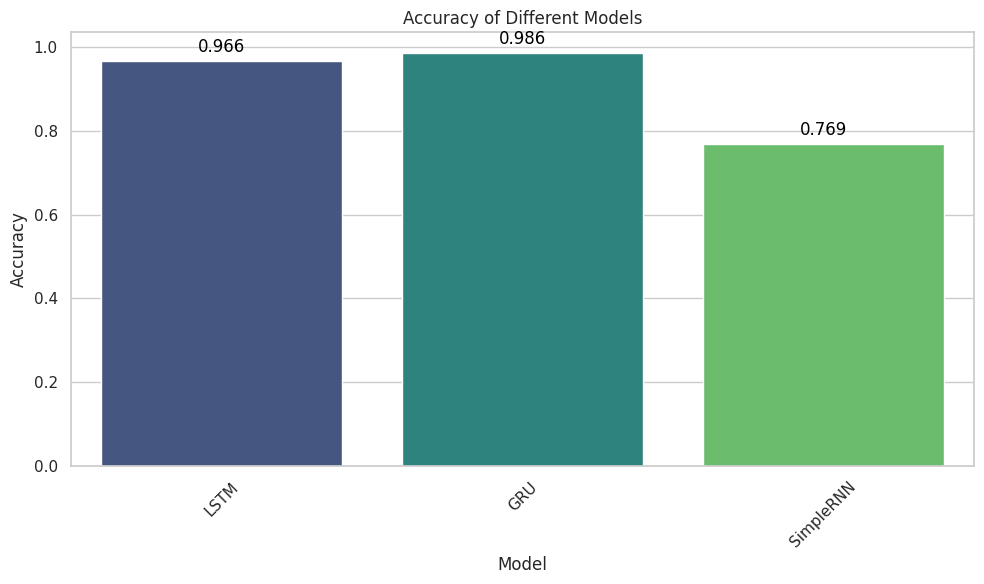

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Model': ['LSTM','GRU','SimpleRNN'],
    'Accuracy': [a_rnn,b_gru,j_snn]
}
df = pd.DataFrame(data)


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


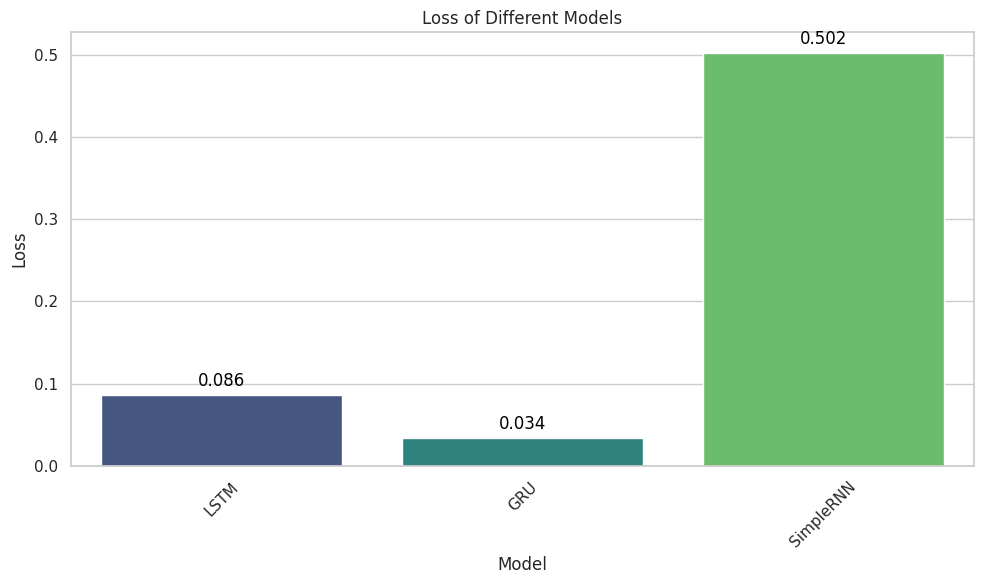

In [90]:
data = {
    'Model': ['LSTM','GRU','SimpleRNN'],
    'Loss': [l_rnn,c_gru,h_snn]
}
df = pd.DataFrame(data)


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Loss', data=df, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Loss of Different Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

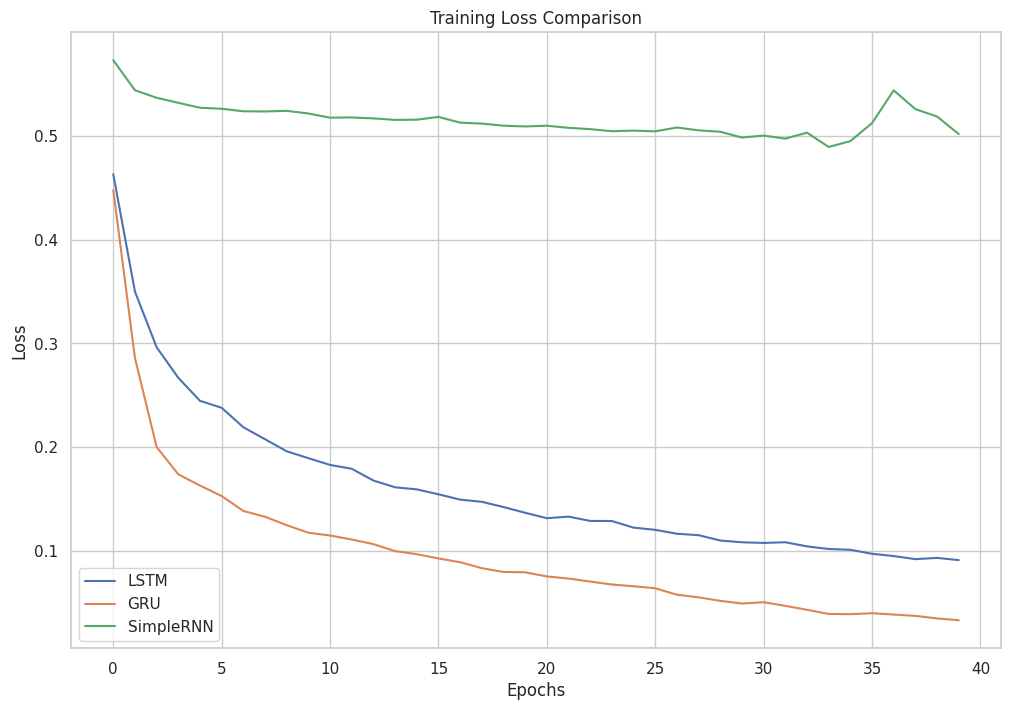

In [91]:
# Plot training loss if accuracy keys are not present
plt.figure(figsize=(12, 8))

plt.plot(RNN_history.history['loss'], label='LSTM')
plt.plot(GRU_history.history['loss'], label='GRU')
plt.plot(SimpleRNN_history.history['loss'], label='SimpleRNN')


plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [92]:
from sklearn.metrics import average_precision_score

# Assuming Y_pred is your model predictions
Y_pred = RNN.predict(X_test)

# Flatten the arrays
y_test_flat = y_test.ravel()  # or y_test.flatten()
Y_pred_flat = Y_pred.ravel()  # or Y_pred.flatten()

# Now, you can calculate the average precision
average_precision_rnn = average_precision_score(y_test_flat, Y_pred_flat)
print('Average Precision:', average_precision_rnn)

223/223 [==============================] - 2s 8ms/step
Average Precision: 0.9958131144330802


In [93]:
# Assuming Y_pred is your model predictions
Y_pred = GRU_model.predict(X_test)

# Flatten the arrays
y_test_flat = y_test.ravel()  # or y_test.flatten()
Y_pred_flat = Y_pred.ravel()  # or Y_pred.flatten()

# Now, you can calculate the average precision
average_precision_gru = average_precision_score(y_test_flat, Y_pred_flat)
print('Average Precision:', average_precision_gru)

223/223 [==============================] - 6s 16ms/step
Average Precision: 0.9993671102605136


In [94]:
# Assuming Y_pred is your model predictions
Y_pred = SimpleRNN_model.predict(X_test)

# Flatten the arrays
y_test_flat = y_test.ravel()  # or y_test.flatten()
Y_pred_flat = Y_pred.ravel()  # or Y_pred.flatten()

# Now, you can calculate the average precision
average_precision_sprnn = average_precision_score(y_test_flat, Y_pred_flat)
print('Average Precision:', average_precision_sprnn)

223/223 [==============================] - 5s 21ms/step
Average Precision: 0.8005913624019023


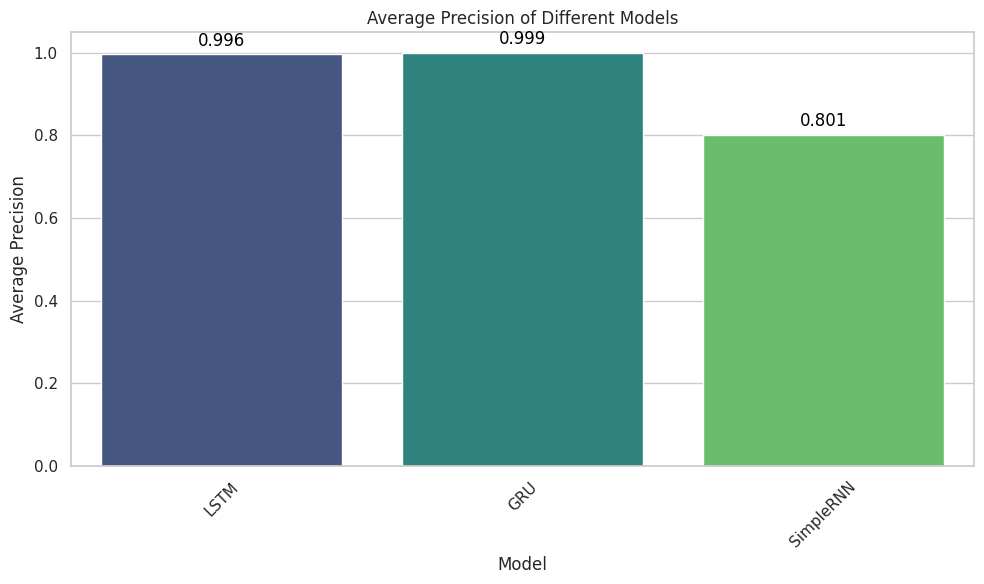

In [95]:
data = {
    'Model': ['LSTM','GRU','SimpleRNN'],
    'Average Precision': [average_precision_rnn,average_precision_gru,average_precision_sprnn]
}
df = pd.DataFrame(data)


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Average Precision', data=df, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Model')
plt.ylabel('Average Precision')
plt.title('Average Precision of Different Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [96]:
print()
print('TRAINING DATASET DIMENSIONS')
print('-'*80)
print('  NUMBER OF TRAINING SERIES : ' + str(NBR_TRAINING_SERIES))
print('  NUMBER OF TRAINING SAMPLES : ' + str(NBR_TRAINING_SAMPLES))
print('  TIMESTEPS PER SAMPLE : ' + str(TIMESTEPS))
print('  NUMBER OF FEATURES : ' + str(NBR_FEATURES ))
print()
print('NEURAL NETWORK TRAINING PARAMETERS')
print('-'*80)
print('  BATCH SIZE : ' + str(BATCH_SIZE))
print('  NUMBER OF EPOCHS : ' + str(EPOCHS))
print()


TRAINING DATASET DIMENSIONS
--------------------------------------------------------------------------------
  NUMBER OF TRAINING SERIES : 200
  NUMBER OF TRAINING SAMPLES : 7136
  TIMESTEPS PER SAMPLE : 150
  NUMBER OF FEATURES : 6

NEURAL NETWORK TRAINING PARAMETERS
--------------------------------------------------------------------------------
  BATCH SIZE : 32
  NUMBER OF EPOCHS : 40



The predicted values are the probabilities of a step belonging to the asleep state. 

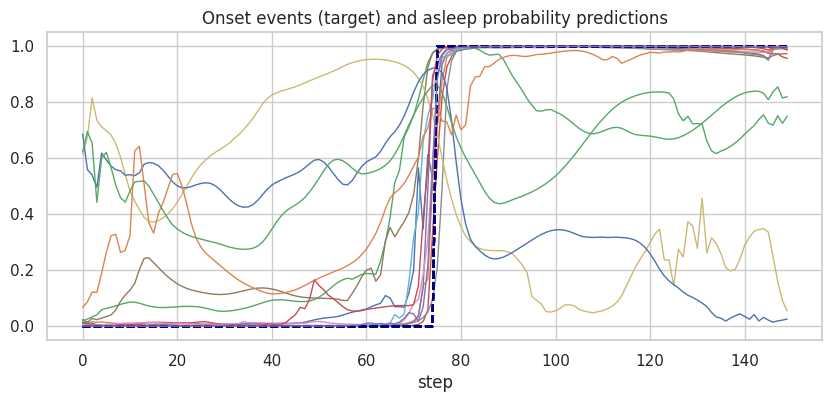

In [97]:
# Onset predictions
fig, ax = plt.subplots(1,1, figsize=(10,4))
for i in range(15):
    ax.set_title('Onset events (target) and asleep probability predictions')
    ax.plot(y_test[i], linestyle='--', color='Navy')
    ax.plot(predicted_values[i], lw=1)
    ax.set_xlabel('step')
plt.show()

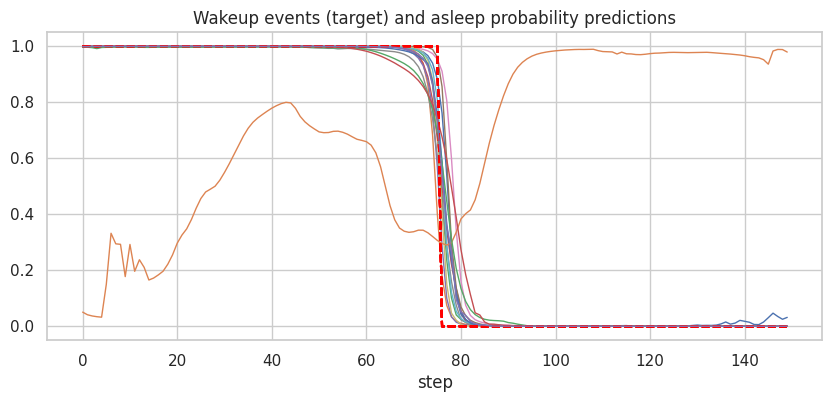

In [98]:
# Wakeup predictions
fig, ax = plt.subplots(1,1, figsize=(10,4))
for i in range(15):
    ax.set_title('Wakeup events (target) and asleep probability predictions')
    ax.plot(y_test[i + nbr_onset_samples], linestyle='--', color='Red')
    ax.plot(predicted_values[i + nbr_onset_samples], lw=1)
    ax.set_xlabel('step')
plt.show()

It seems to be predicting the asleep state reasonably well, even taking into account the testing is done over the same samples the model was trained with (in-sample test), and also that the train and test sequencies are just 150 steps (12.5 minutes). But it does not look bad for a start.

In [99]:
predicted_values.shape

(7136, 150, 1)

In [100]:
# Convert predicted asleep probabilities to binary state
predicted_asleep_state = np.where(predicted_values > 0.5, 1, 0 )
predicted_asleep_state.T

array([[[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]])

In [101]:
predicted_asleep_state.shape

(7136, 150, 1)

Only left is to identify the step at which the wakeup event occurs. To do this, I will calculate the diff of the asleep column.

In [111]:
df.index

RangeIndex(start=0, stop=3, step=1)

In [112]:
# Save the RNN model
RNN_name = 'RNN_' + str(NBR_TRAINING_SERIES) + '_SERIES_' + str(EPOCHS)+ '_EPOCHS'
RNN.save(RNN_name)

In [113]:
# Recovering memory
gc.collect()

126870

### Make predictions for submission
---

There is something wrong somwwhere that will result in an "exception" error" if a submission is attempted. Never mind, I fixed it somewhere else.

Just in case you find your self in such situation, the question you have to ask yourself is: *"What is it that could be so beautifully working in this interactive session, and could however fail in the hidden set evaluation?"*

Based on my experience, usual suspects are:
- hardcoded values (remember hidden data is different to the small test_series set provided)
- addition of probabilities from different predictions (use clip(0,1))
- manipulating files, changing directory and then saving the submission file in the wrong place (use pwd)
- ....

Just persevere.... and you will find it.


In [114]:
test_series

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.64,2.17e-02
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.64,2.15e-02
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.64,2.16e-02
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.64,2.13e-02
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.64,2.15e-02
...,...,...,...,...,...
445,0402a003dae9,145,2018-12-18T12:57:05-0500,-59.70,6.01e-02
446,0402a003dae9,146,2018-12-18T12:57:10-0500,-35.66,4.27e-02
447,0402a003dae9,147,2018-12-18T12:57:15-0500,-21.58,3.09e-02
448,0402a003dae9,148,2018-12-18T12:57:20-0500,-42.62,3.28e-02


In [115]:
test_series['step'] = test_series['step'].astype(np.int64) 
test_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  450 non-null    object 
 1   step       450 non-null    int64  
 2   timestamp  450 non-null    object 
 3   anglez     450 non-null    float32
 4   enmo       450 non-null    float32
dtypes: float32(2), int64(1), object(2)
memory usage: 14.2+ KB


In [116]:
test_series_ids = list(test_series['series_id'].unique())
NBR_TEST_SERIES = len(test_series_ids)
TIMESTEPS_PER_SAMPLE = 150

print('Nbr. test series for submission: ' + str(NBR_TEST_SERIES))
print(test_series_ids)

Nbr. test series for submission: 3
['038441c925bb', '03d92c9f6f8a', '0402a003dae9']


In [117]:
def sample_test_series(df):
    # Create dictionary of test sequences
    series = {}
    # Iterate through the samples
    for id in test_series_ids:
        series[id] = df[df['series_id']==id].reset_index(drop=True)
        n_steps = len(series[id])
        n_samples = n_steps // TIMESTEPS_PER_SAMPLE
        l_samples = list(range(n_samples))
        samples = {}
        for s in l_samples:
            first_step = TIMESTEPS_PER_SAMPLE * s
            samples[s] = series[id].loc[first_step : first_step + TIMESTEPS_PER_SAMPLE - 1]
    series[id] = pd.concat([samples[s] for s in l_samples], axis='rows')

    # Concatenate samples into single test dataframe
    df = pd.concat([series[id] for id in test_series_ids], axis='rows').reset_index(drop=True)
    # Return updated dataframe
    return df
        
# Resample test_series dataset into set of sequences of 150 steps
test_series = sample_test_series(test_series)

In [118]:
def create_features(df):
    # Create dictionary of test sequences
    series = {}
    # Iterate through the samples to create derived features
    for id in test_series_ids:
        series[id] = df[df['series_id']==id]
        series[id]['anglez_diff'] = series[id]['anglez'].diff().fillna(method='bfill').fillna(method="ffill")   
        series[id]['enmo_diff'] = series[id]['enmo'].diff().fillna(method='bfill').fillna(method="ffill")   
        series[id]['anglez_ma'] = series[id]['anglez'].rolling(12).mean().fillna(method='bfill').fillna(method="ffill")    
        series[id]['enmo_ma'] = series[id]['enmo'].rolling(12).mean().fillna(method='bfill').fillna(method="ffill")   
    # Concatenate samples into single test dataframe
    df = pd.concat([series[id] for id in test_series_ids], axis=0)
    # Return updated dataframe
    return df

# Creature derived features
test_series = create_features(test_series)

In [119]:
def make_predictions(df):
    # Prepare input sequences for RNN
    features = ['anglez', 'enmo', 'anglez_diff', 'enmo_diff',  'anglez_ma', 'enmo_ma']
    NBR_FEATURES = len(features)
    TEST_SERIES_STEPS = len(df)

    # Isolate test set predictors
    X_test = df[features].to_numpy().reshape(NBR_TEST_SERIES, TIMESTEPS_PER_SAMPLE, NBR_FEATURES)
    # Make submission predictions (probabilities of asleep)
    test_predictions = RNN.predict(X_test)
    # Make binary asleep predictions (1=asleep)
    test_classes = np.where(test_predictions > 0.5, 1,0)
    # Reshape
    test_predictions = test_predictions.reshape(TEST_SERIES_STEPS, 1)
    test_classes = test_classes.reshape(TEST_SERIES_STEPS, 1) 
    
    # Create asleep and event predictions columns
    df['score'] = test_predictions
    df ['asleep'] =  test_classes
    df['asleep_diff'] = df['asleep'].diff().fillna(method='bfill').fillna(method="ffill")
    df['event'] = df[df['score']>0.4]['asleep_diff'].replace({1 : 'onset', -1 : 'wakeup'})
    
    return df

# Make predictions
test_series = make_predictions(test_series)

1/1 [==============================] - 1s 716ms/step


In [120]:
test_series.sample(10)



,series_id,step,timestamp,anglez,enmo,anglez_diff,enmo_diff,anglez_ma,enmo_ma,score,asleep,asleep_diff,event
94,038441c925bb,94,2018-08-14T15:37:50-0400,-79.98,0.01,6.40e-03,0.00e+00,-80.00,0.01,9.54e-01,1,0.0,0.0
287,03d92c9f6f8a,137,2018-05-31T12:11:25-0400,-88.22,0.00,0.00e+00,0.00e+00,-88.22,0.00,9.61e-01,1,0.0,0.0
380,0402a003dae9,80,2018-12-18T12:51:40-0500,-23.53,0.02,1.96e+01,-6.39e-02,-44.46,0.05,2.71e-02,0,0.0,NaN
89,038441c925bb,89,2018-08-14T15:37:25-0400,-79.97,0.01,2.80e-03,7.00e-04,-79.99,0.01,9.66e-01,1,0.0,0.0
271,03d92c9f6f8a,121,2018-05-31T12:10:05-0400,-88.22,0.00,0.00e+00,0.00e+00,-88.22,0.00,9.85e-01,1,0.0,0.0
281,03d92c9f6f8a,131,2018-05-31T12:10:55-0400,-88.22,0.00,0.00e+00,0.00e+00,-88.22,0.00,9.72e-01,1,0.0,0.0
307,0402a003dae9,7,2018-12-18T12:45:35-0500,-16.59,0.07,2.21e+00,-8.70e-03,-31.37,0.05,1.92e-01,0,0.0,NaN
134,038441c925bb,134,2018-08-14T15:41:10-0400,-80.02,0.01,1.39e-01,2.00e-04,-80.17,0.01,8.46e-01,1,0.0,0.0
285,03d92c9f6f8a,135,2018-05-31T12:11:15-0400,-88.22,0.00,0.00e+00,0.00e+00,-88.22,0.00,9.65e-01,1,0.0,0.0
397,0402a003dae9,97,2018-12-18T12:53:05-0500,-40.55,0.63,-9.90e+00,6.09e-01,-8.55,0.15,5.88e-03,0,0.0,NaN


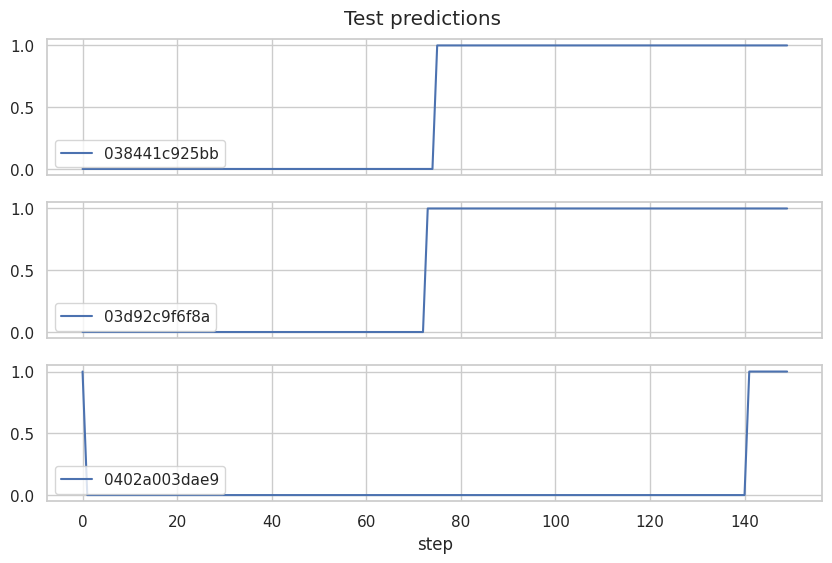

In [121]:
fig, ax = plt.subplots(3,1, figsize=(10,6), sharex=True)
fig.suptitle('Test predictions', y=0.93)
i = 0
for id in test_series_ids:
    ax[i].plot(test_series[test_series['series_id']==id]['step'],
               test_series[test_series['series_id']==id]['asleep'],
               lw=1.5, label=id)
    ax[i].legend(loc='lower left')
    i = i + 1
plt.xlabel('step')
plt.show()

In [122]:
# Isolate events and add row_id
submission_df = test_series.loc[((test_series["event"]=='onset') |
                                 (test_series["event"]=='wakeup'))
                               ][["series_id","step","event","score"]].copy().reset_index(drop=True).reset_index(names="row_id")

submission_df

,row_id,series_id,step,event,score
0,0,038441c925bb,75,onset,0.66
1,1,03d92c9f6f8a,73,onset,0.57
2,2,0402a003dae9,1,wakeup,0.44
3,3,0402a003dae9,141,onset,0.61


In [124]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row_id     4 non-null      int64  
 1   series_id  4 non-null      object 
 2   step       4 non-null      int64  
 3   event      4 non-null      object 
 4   score      4 non-null      float32
dtypes: float32(1), int64(2), object(2)
memory usage: 272.0+ bytes


In [125]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row_id     6 non-null      int64  
 1   series_id  6 non-null      object 
 2   step       6 non-null      int64  
 3   event      6 non-null      object 
 4   score      6 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 368.0+ bytes


In [126]:
# Save submission data to csv file
submission_df.to_csv('submission.csv', index=False)
print('finished')

finished
